Text(0, 0.5, 'P error')

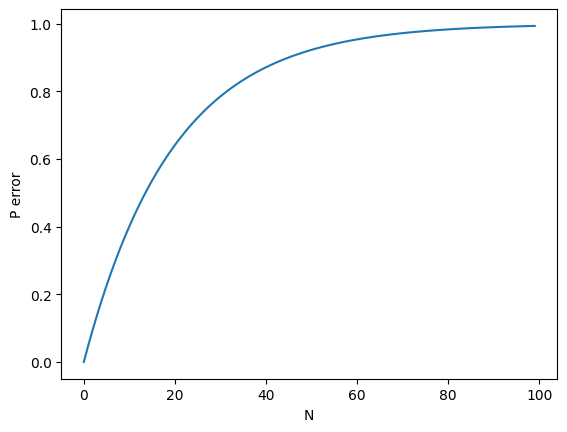

In [2]:
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.05
N = np.arange(0,100)
plt.plot(N, 1-(1-alpha)**N)
plt.xlabel('N')
plt.ylabel('P error')

Probability of getting a type 1 error (y axis) increases as N increases.

Exercise: In this exercise we will run through an example of correcting for multiple comparisons with both the Benjamini-Hochberg procedure and the more conservative Bonferroni correction.

First, simulate multiple (say, 1000) t-tests comparing two samples with equal means and standard deviations, and save the p-values. Obviously, at p<0.05 we expect that ~5% of the simulations to yield a "statistically significant" result (of rejecting the NULL hypothesis that the samples come from distributions with equal means).

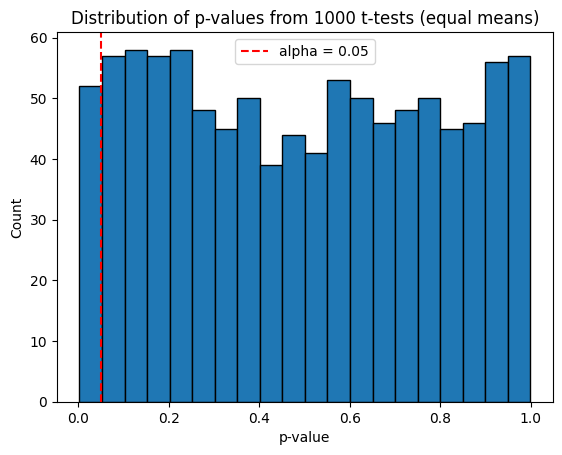

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Function to simulate t-tests and return p-values. Two samples with equal means and standard deviations.
def simulate_ttests(n_tests=1000, sample_size=30, mean1=0, mean2=0, sd=1):
    """Simulate n_tests two-sample t-tests and return p-values."""
    p_values = []
    for _ in range(n_tests):
        group1 = np.random.normal(mean1, sd, sample_size)
        group2 = np.random.normal(mean2, sd, sample_size)
        _, p_val = stats.ttest_ind(group1, group2)
        p_values.append(p_val)
    return np.array(p_values)

# Simulate 1000 t-tests and store p-values using the function
n_tests = 1000
sample_size = 30 #sets the number of data points in each group for every simulated t-test.

p_values_equal = simulate_ttests(n_tests=n_tests, sample_size=sample_size, mean1=0, mean2=0)

# Plot histogram of p-values
# ~5% of the simulations should yield a "statistically significant" result (of rejecting the NULL hypothesis that the samples come from distributions with equal means).
plt.hist(p_values_equal, bins=20, edgecolor="black")
plt.axvline(0.05, color="red", linestyle="--", label="alpha = 0.05")
plt.title("Distribution of p-values from 1000 t-tests (equal means)")
plt.xlabel("p-value")
plt.ylabel("Count")
plt.legend()
plt.show()


Second, once you have the simulated p-values, apply both methods to address the multiple comparisons problem.

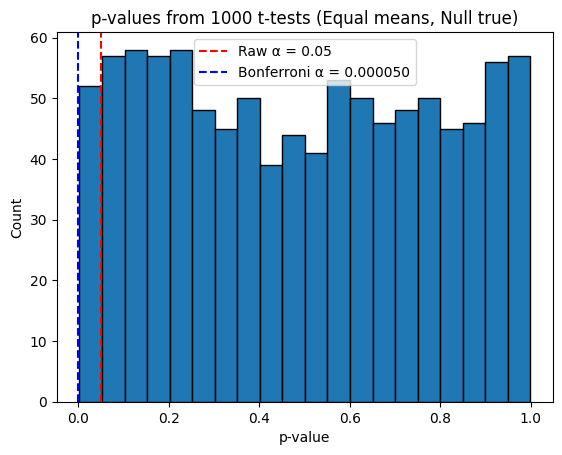

Multiple Comparison Corrections (Equal Means, Null True)
-----------------------------------------------------
Raw (p < 0.05): 46 out of 1000
Bonferroni threshold: 0.000050
Bonferroni significant: 0 out of 1000
Benjamini–Hochberg significant: 0 out of 1000


In [30]:
# Bonferroni correction
alpha = 0.05
bonferroni_alpha = alpha / n_tests #Bonferroni rule: if you run many tests, make threshold stricter by dividing α by number of tests.
bonferroni_significant = np.sum(p_values_equal < bonferroni_alpha) #count how many of the 1000 p-values are below that stricter threshold/how many are significant after Bonferroni correction.

# Benjamini-Hochberg correction
reject_bh, pvals_corrected_bh, _, _ = smm.multipletests(p_values_equal, alpha=alpha, method='fdr_bh') 
    #smm.multipletests: function from statsmodels that applies multiple comparison corrections. method = fdr_bh: Benjamini–Hochberg false discovery rate method.
bh_significant = np.sum(reject_bh) #count how many tests are significant under BH correction.

# Find BH cutoff (max p-value declared significant, if any)
bh_cutoff = p_values_equal[reject_bh].max() if bh_significant > 0 else None

# --- Plot histogram with thresholds ---
plt.hist(p_values_equal, bins=20, edgecolor="black")
plt.axvline(0.05, color="red", linestyle="--", label="Raw α = 0.05")
plt.axvline(bonferroni_alpha, color="blue", linestyle="--", label=f"Bonferroni α = {bonferroni_alpha:.6f}")

if bh_cutoff:
    plt.axvline(bh_cutoff, color="green", linestyle="--", label=f"BH cutoff ≈ {bh_cutoff:.4f}")

plt.title("p-values from 1000 t-tests (Equal means, Null true)")
plt.xlabel("p-value")
plt.ylabel("Count")
plt.legend()
plt.show()

# --- Print summary ---
print("Multiple Comparison Corrections (Equal Means, Null True)")
print("-----------------------------------------------------")
print(f"Raw (p < 0.05): {np.sum(p_values_equal < alpha)} out of {n_tests}")
print(f"Bonferroni threshold: {bonferroni_alpha:.6f}")
print(f"Bonferroni significant: {bonferroni_significant} out of {n_tests}")
print(f"Benjamini–Hochberg significant: {bh_significant} out of {n_tests}")

Third, set the sample 1 and sample 2 means to be 1 and 2 respectively, and re-run the exercise. What do you notice? What if you make the difference between means even greater?

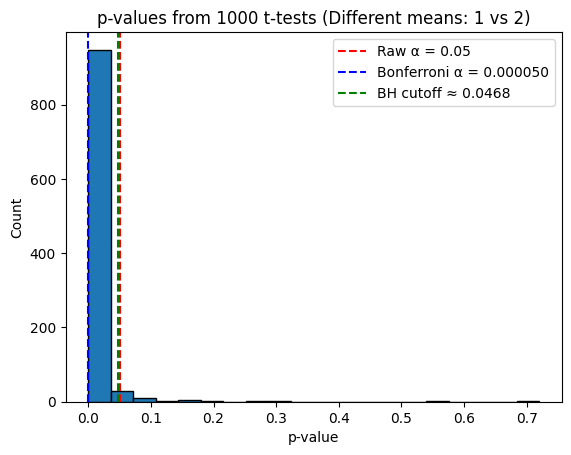

Multiple Comparison Corrections (Different Means, True Effect)
------------------------------------------------------------
Raw (p < 0.05): 959 out of 1000
Bonferroni threshold: 0.000050
Bonferroni significant: 300 out of 1000
Benjamini–Hochberg significant: 958 out of 1000


In [31]:
# Repeat simulation with true effect (means different for sample 1 and 2)
p_values_diff = []
for _ in range(n_tests):
    group1 = np.random.normal(1, 1, sample_size)
    group2 = np.random.normal(2, 1, sample_size)
    t_stat, p_val = stats.ttest_ind(group1, group2)
    p_values_diff.append(p_val)
p_values_diff = np.array(p_values_diff)

# Bonferroni correction with effect
bonferroni_significant_diff = np.sum(p_values_diff < bonferroni_alpha)

# Benjamini-Hochberg with effect
reject_bh_diff, pvals_corrected_bh_diff, _, _ = smm.multipletests(p_values_diff, alpha=alpha, method='fdr_bh')
bh_significant_diff = np.sum(reject_bh_diff) #count how many tests are significant under BH correction.


# Find BH cutoff (max p-value declared significant, if any)
bh_cutoff_diff = p_values_diff[reject_bh_diff].max() if bh_significant_diff > 0 else None

# --- Plot histogram with thresholds ---
plt.hist(p_values_diff, bins=20, edgecolor="black")
plt.axvline(0.05, color="red", linestyle="--", label="Raw α = 0.05")
plt.axvline(bonferroni_alpha, color="blue", linestyle="--", label=f"Bonferroni α = {bonferroni_alpha:.6f}")

if bh_cutoff_diff:
    plt.axvline(bh_cutoff_diff, color="green", linestyle="--", label=f"BH cutoff ≈ {bh_cutoff_diff:.4f}")

plt.title("p-values from 1000 t-tests (Different means: 1 vs 2)")
plt.xlabel("p-value")
plt.ylabel("Count")
plt.legend()
plt.show()

# --- Print summary ---
print("Multiple Comparison Corrections (Different Means, True Effect)")
print("------------------------------------------------------------")
print(f"Raw (p < 0.05): {np.sum(p_values_diff < alpha)} out of {n_tests}")
print(f"Bonferroni threshold: {bonferroni_alpha:.6f}")
print(f"Bonferroni significant: {bonferroni_significant_diff} out of {n_tests}")
print(f"Benjamini–Hochberg significant: {bh_significant_diff} out of {n_tests}")


The Bonferroni test is alot more conservative/strict than the Benjamin-Hochberg test. Much fewer results are considered significant after the bonferroni correction compared to the BH correction. 
While the Bonferroni test avoids false positives more so than the BH test, the Bonferroni test misses alot of true effects that the BH test detects.